In [1]:
import os, arrow
from elasticsearch import Elasticsearch
from datetime import datetime
from config import SOC_ES_HOST,SOC_ES_USER, SOC_ES_PASSWORD, SOC_ES_PORT

import requests
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
import nltk

In [2]:
es = Elasticsearch([SOC_ES_HOST], http_auth=(SOC_ES_USER, SOC_ES_PASSWORD), port=SOC_ES_PORT, timeout=60)


In [3]:
def set_el_string(query:str) -> str:
     return "%s" %query.replace('|', 'OR')\
        .replace('/', '')\
        .replace('&', ' AND ')


index = 'streamfr'
query = 'title:Covid AND language:fr AND smitype:4'
data = []
doc = {"query": {"query_string": {"query": query, "default_operator": "AND"}},"size": 10000}



def get_news(index : str, keyword: dict , query= str, start = int(arrow.utcnow().shift(hours= -24).timestamp())
             ,end = int(arrow.utcnow().timestamp()),doc=doc):

    query = set_el_string(keyword['keywords']) + " AND " + query + " AND timestamp:[{} TO {}]".format(start, end)
    print(query)

    if es.indices.exists(index=index):
            res = es.search(index = index,body= doc ,scroll="1m")

            while res['hits']['hits']:
                try:
                    sid = res['_scroll_id']
                    # get batch with data
                    scroll_res = res['hits']['hits']
                    data.extend(scroll_res)
                    # get next batch
                    res = es.scroll(scroll_id=sid, scroll="1m")
                except KeyError:
                    break
    else:
         return []
    return data


In [7]:
import pandas as pd
from datetime import timezone

keywords = {}
keywords['keywords'] = 'covid' 
keywords = {'keywords': "id:100057438729357" }

dataset = []
df = pd.DataFrame()
    
query = "title:Covid AND language:fr AND smitype:4 AND fixdate:2023-03-05"
data = get_news(query = query,keyword=keywords,index=index, start = datetime(2020,1,1),end=datetime(2020,1,7))

for item in data:
    dataset.append(item['_source'])

tmp = pd.DataFrame.from_dict(dataset)
df = df.append(tmp)


id:100057438729357 AND title:Covid AND language:fr AND smitype:4 AND fixdate:2023-03-05 AND timestamp:[2020-01-01 00:00:00 TO 2020-01-07 00:00:00]


/tmp/ipykernel_28136/921698498.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp)


In [8]:
df.shape

(12800, 24)

In [9]:
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop

# Tokenize and remove unwanted words.


def preprocess_text(text):
    nltk.download('punkt')
    nltk.download('stopwords')
    tokens = word_tokenize(text.lower())
    french_stopwords = set(stopwords.words('french'))

    # Updated after first experiment, ask Yves if there are any words here that he doesn't want to remove
    missed_stopword_list = ['a','plus','cas','cette','depuis','contre','ans','après','fait', 'selon', 'aussi', 'moins', 'comme', 'être',
                         'si', 'tout', 'millions', 'très', 'faire', 'encore','dont','où', 'entre', 'avoir','autre','autres', 'sans', 'suite', 'alors'
                         , 'chez', 'déjà', 'ainsi', 'peu' , 'leurs']

    stopwords_from_spacy = list(fr_stop)
    french_stopwords.update(missed_stopword_list)
    french_stopwords.update(stopwords_from_spacy)
    unwanted_tokens = french_stopwords.union({"'", "’", "-", "»", "«"})
    filtered_tokens = [token for token in tokens if token not in unwanted_tokens and token.isalpha()]
    return filtered_tokens

def count_words(tokens):
    return Counter(tokens)


# to remove html tags
def extract_text(articles):
    ''' input: List of article
        returns:
            whole text without html tags
    '''
    text = ""
    for article in articles:
        soup = BeautifulSoup(article, 'html.parser')
        text += soup.get_text()
    return text

def extract_text_from_single_article(article):
    '''
    input : 
            Single article
    returns :  
            Text version of article without html tags
    '''
    soup = BeautifulSoup(article, 'html.parser')
    return soup.get_text()




In [10]:
df = df.dropna(subset=['text'])
df['cleaned_text'] = df['text'].apply(extract_text_from_single_article)
df['prepocessed_text'] = df['cleaned_text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /home/zeki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zeki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zeki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zeki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zeki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zeki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zeki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zeki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to

In [31]:
import pandas as pd
from collections import Counter

# Set M as the number of top frequent words to consider
M = 100

# Get the top M most frequent words
all_words = []
for tokens in df['prepocessed_text']:
    all_words.extend(tokens)
word_frequencies = Counter(all_words)
top_100_words_with_freq = [(word,freq) for word, freq in word_frequencies.most_common(M)]
top_100_words = [word for word,_ in word_frequencies.most_common(M)]



In [24]:
from itertools import combinations

# Function to create word pairs from an article's preprocessed text
def create_word_pairs(top_M_words):
    words = set(top_M_words)
    return set(combinations(words, 2))

In [33]:
# Create a co-occurrence matrix for the specific words
cooccurrence_matrix = pd.DataFrame(0, index=top_100_words, columns=top_100_words)

# Fill the co-occurrence matrix
for tokens in df['prepocessed_text']:
    for word_1 in set(tokens):
        if word_1 in top_100_words:
            for word_2 in set(tokens):
                if word_2 in top_100_words:
                    cooccurrence_matrix.loc[word_1, word_2] += 1
                    if word_1 != word_2:
                        cooccurrence_matrix.loc[word_2, word_1] += 1

# Display the co-occurrence matrix
print(cooccurrence_matrix)

             personnes  santé  covid  mars  pays  france  nombre  chine  \
personnes         6694   8220   6852  5772  5376    5164    6492   2864   
santé             8220   6464   6512  5432  5308    4988    6184   2852   
covid             6852   6512   5930  4700  4964    4196    4692   3648   
mars              5772   5432   4700  4712  3400    3720    4184   1776   
pays              5376   5308   4964  3400  4696    3300    4416   3764   
...                ...    ...    ...   ...   ...     ...     ...    ...   
pass              1544   1584   1136  1516   584    1488    1188    132   
décembre          1988   2108   2292  1164  2040    1260    1720   1504   
mis               2308   2504   2376  1756  2160    1488    1580   1348   
samedi            1936   1632   1552  1228  1136     940    1408    724   
indicateurs       1372    872    512   680   672    1232    1300     48   

             pandémie  sanitaire  ...  chinois  confinement  baisse  déclaré  \
personnes        49

In [65]:
def get_occurence(word_1,word_2,cooccurrence_matrix):
    occ = cooccurrence_matrix.loc[word_1,word_2]
    return occ

# Create the covariance matrix
n = len(top_100_words)
covariance_matrix = np.zeros((n, n))
A=(df.shape[0])

for i, (word_1, frequency_1) in enumerate(top_100_words_with_freq):
    for j, (word_2, frequency_2) in enumerate(top_100_words_with_freq):
        covariance = np.abs(get_occurence(word_1, word_2, cooccurrence_matrix) / A - frequency_1 * frequency_2 / (A ** 2))
        covariance_matrix[i, j] = covariance



In [66]:
print("Covariance matrix of top 100 words:")
print(covariance_matrix)

Covariance matrix of top 100 words:
[[1.10162716 0.84951433 0.88890229 ... 0.0952507  0.12434048 0.16844432]
 [0.84951433 0.86489771 0.79907926 ... 0.05739436 0.12558328 0.185014  ]
 [0.88890229 0.79907926 0.78533671 ... 0.05593603 0.12037144 0.20169768]
 ...
 [0.0952507  0.05739436 0.05593603 ... 0.12728525 0.01425369 0.03427246]
 [0.12434048 0.12558328 0.12037144 ... 0.01425369 0.06582138 0.03427246]
 [0.16844432 0.185014   0.20169768 ... 0.03427246 0.03427246 0.01452329]]


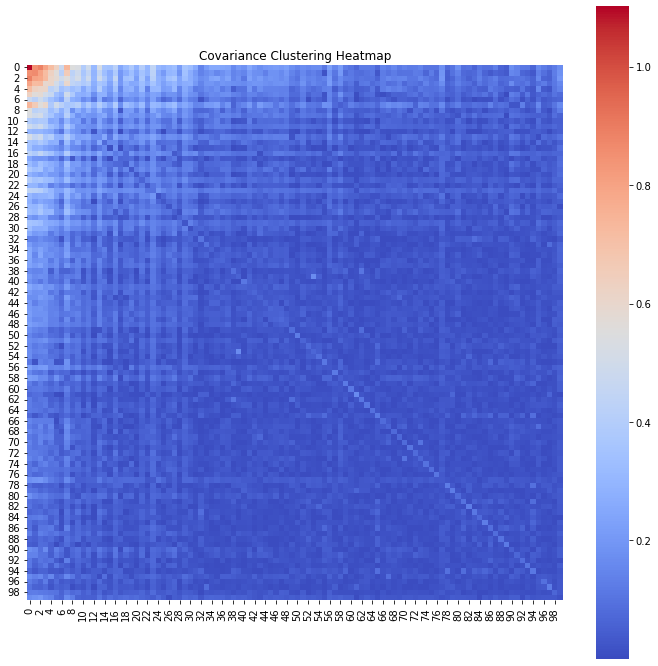

In [67]:
plt.figure(figsize=(12, 12))
sns.heatmap(covariance_matrix, cmap='coolwarm', square=True, annot=False, cbar=True)
plt.title('Covariance Clustering Heatmap')
plt.show()

In [68]:
import numpy as np

# Assume `cov_matrix` is your covariance matrix (a NumPy array)
cov_matrix = covariance_matrix

# Compute the standard deviations of the variables
std_devs = np.sqrt(np.diag(cov_matrix))

# Normalize the covariance matrix to obtain the correlation matrix
correlation_matrix = cov_matrix / np.outer(std_devs, std_devs)


In [69]:
correlation_matrix

array([[1.        , 0.87030409, 0.95567177, ..., 0.25436762, 0.46175512,
        1.33170059],
       [0.87030409, 1.        , 0.96957082, ..., 0.17298075, 0.52633951,
        1.65078209],
       [0.95567177, 0.96957082, 1.        , ..., 0.17691908, 0.52943423,
        1.8886022 ],
       ...,
       [0.25436762, 0.17298075, 0.17691908, ..., 1.        , 0.15572373,
        0.79712007],
       [0.46175512, 0.52633951, 0.52943423, ..., 0.15572373, 1.        ,
        1.10848366],
       [1.33170059, 1.65078209, 1.8886022 , ..., 0.79712007, 1.10848366,
        1.        ]])

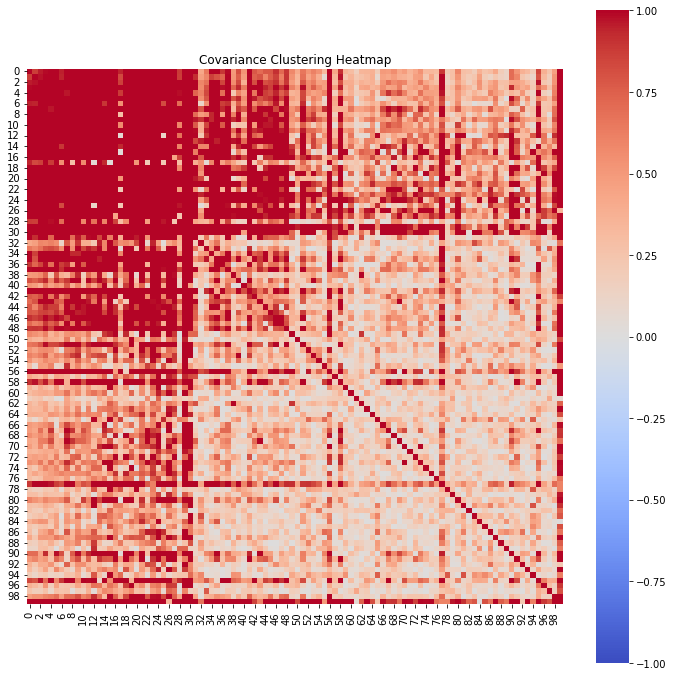

In [70]:
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm',vmin=-1, vmax=1, square=True, annot=False, cbar=True)
plt.title('Covariance Clustering Heatmap')
plt.show()

# NOW WE WILL NOT DO FROM SCRATCH BUT USE PACKAGES

In [71]:
import numpy as np
import pandas as pd


# Create a pandas DataFrame from the co-occurrence matrix
cooccurrence_df = pd.DataFrame(cooccurrence_matrix)

# Calculate the covariance matrix
covariance_matrix_py = cooccurrence_df.cov()

# Calculate the correlation matrix
correlation_matrix_py = cooccurrence_df.corr()


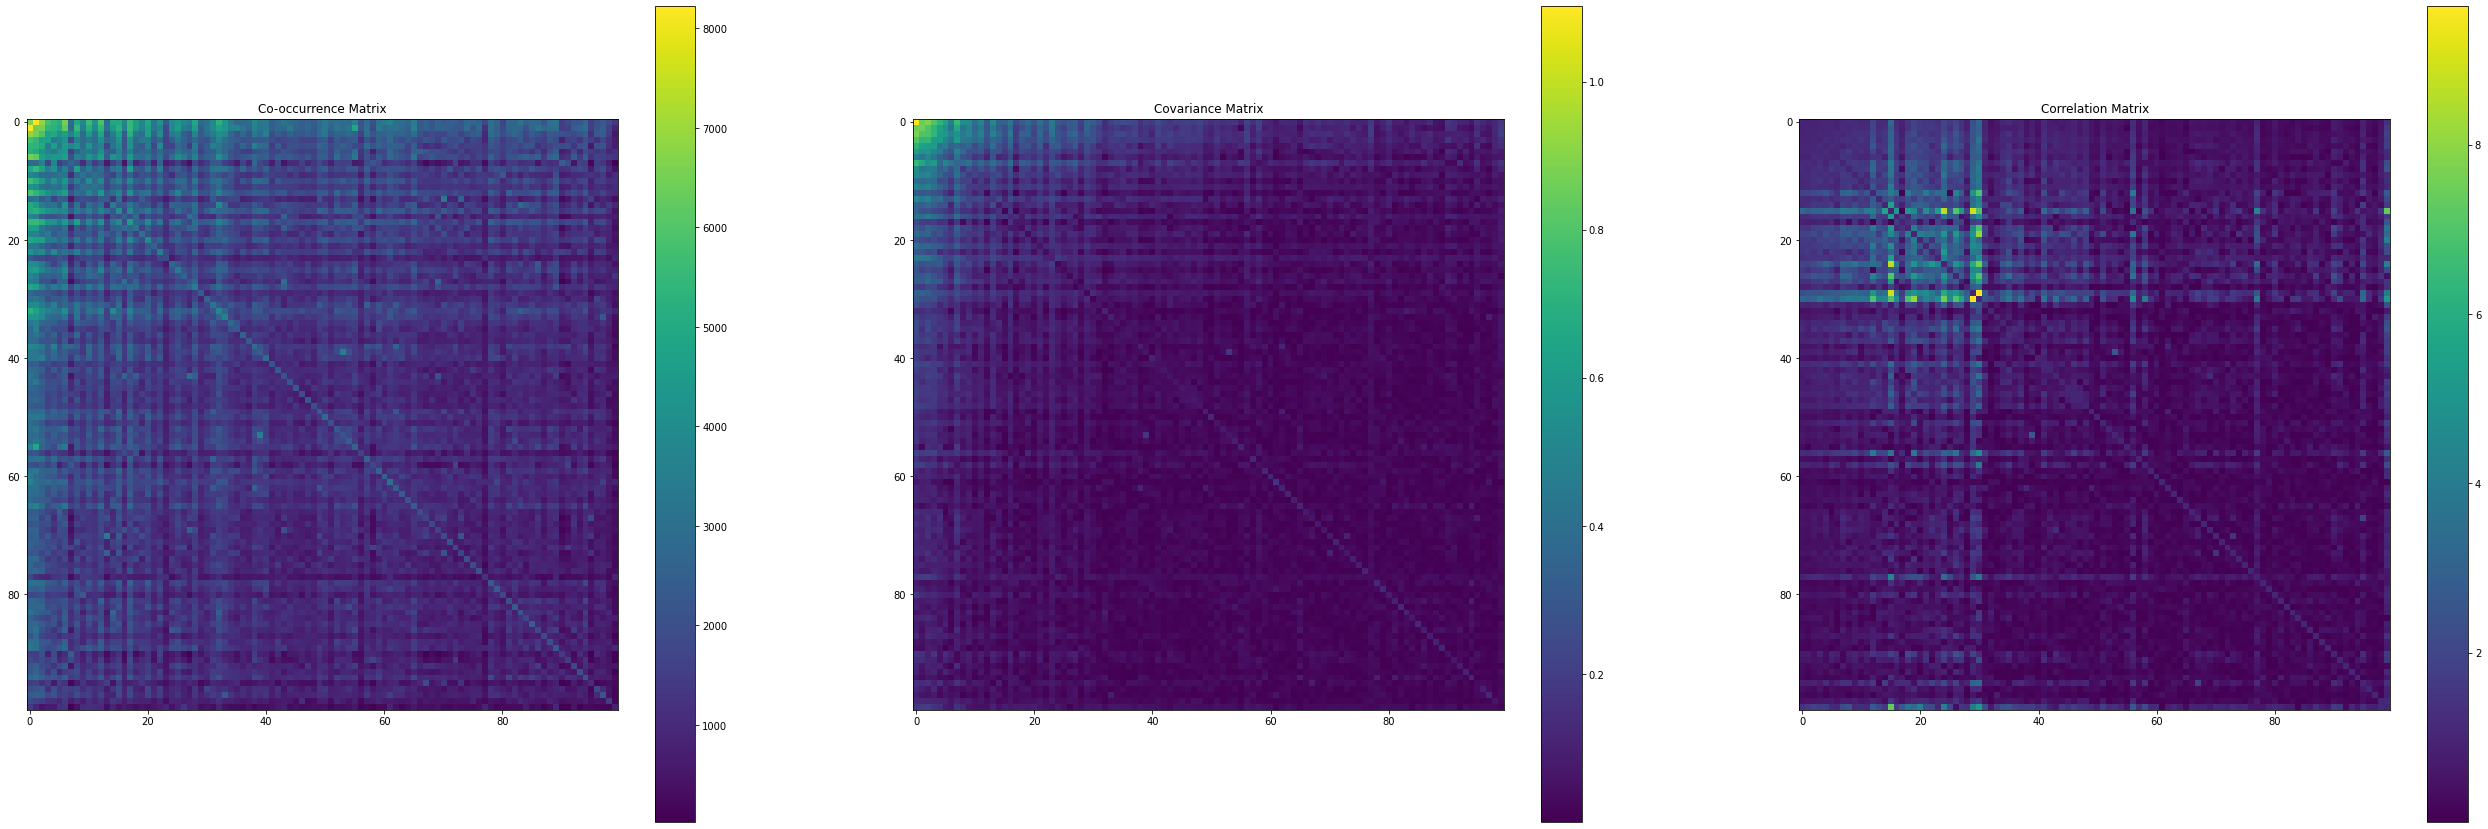

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(45, 15))

# Co-occurrence matrix
im1 = axes[0].imshow(cooccurrence_matrix, cmap='viridis')
axes[0].set_title('Co-occurrence Matrix')
fig.colorbar(im1, ax=axes[0])

# Covariance matrix
im2 = axes[1].imshow(covariance_matrix, cmap='viridis')
axes[1].set_title('Covariance Matrix')
fig.colorbar(im2, ax=axes[1])

# Correlation matrix
im3 = axes[2].imshow(correlation_matrix, cmap='viridis')
axes[2].set_title('Correlation Matrix')
fig.colorbar(im3, ax=axes[2])

plt.show()

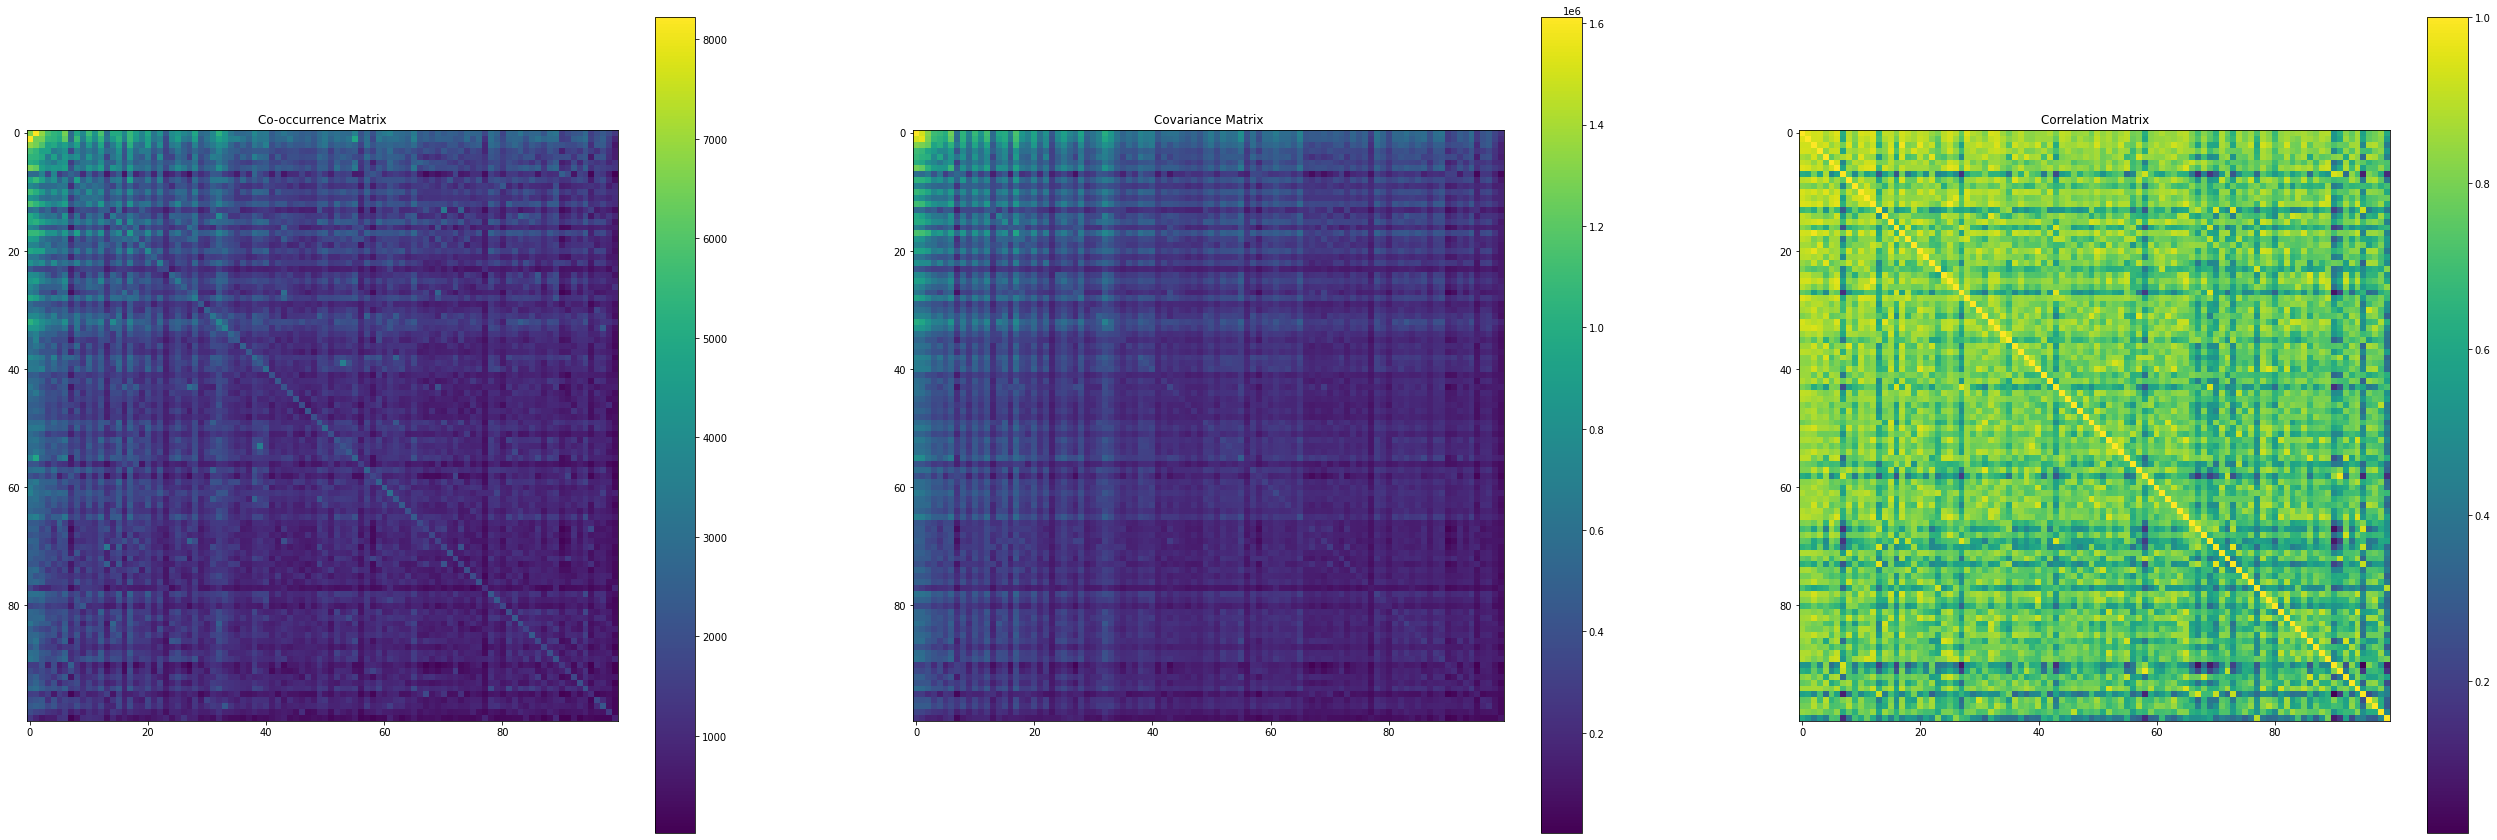

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(45, 15))

# Co-occurrence matrix
im1 = axes[0].imshow(cooccurrence_matrix, cmap='viridis')
axes[0].set_title('Co-occurrence Matrix')
fig.colorbar(im1, ax=axes[0])

# Covariance matrix
im2 = axes[1].imshow(covariance_matrix_py, cmap='viridis')
axes[1].set_title('Covariance Matrix')
fig.colorbar(im2, ax=axes[1])

# Correlation matrix
im3 = axes[2].imshow(correlation_matrix_py, cmap='viridis')
axes[2].set_title('Correlation Matrix')
fig.colorbar(im3, ax=axes[2])

plt.show()